DEBUG arrival_policy = park_no_charge max_wait_minutes = None


Charging strategy: GENERATION
Strategy status:   ACTIVE
Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 10
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-03 23:45:00
Simulationshorizont: 3 Tage
Kalenderische Tage je Tagtyp:
- working_day: 3 Tage
- saturday: 0 Tage
- sunday_holiday: 0 Tage
arrival_blocking_policy in YAML: park_no_charge
max_wait_minutes in YAML: 0

📊 Sessions im Simulationshorizont
Sessions gesamt (Ankünfte mit Ladebedarf): 80
Sessions physisch angesteckt: 44

🚦 Arrival-Blocking KPIs
Rejected (drive_off / max_wait): 0
Parked but not charged: 36

🔎 Beispiel-Sessions (erste 10):
Fahrzeug: 1# Pro Plus, Ankunft: 2025-12-01 06:04:29.415070, Abfahrt: 2025-12-01 15:39:52.730099, Kapazität: 66.0 kWh, geladene Energie: 14.9 kWh, Restbedarf: 0.0 kWh, angesteckt: Ja
Fahrzeug: 500e Hatchback, Ankunft: 2025-12-01 06:49:26.829258, Abfahrt: 2025-12-01 15:25:23.665407, Kapazität: 42.0 kWh, geladene Energie: 10.4 kWh, Restbedarf: 0.0 kWh, angesteckt: Ja

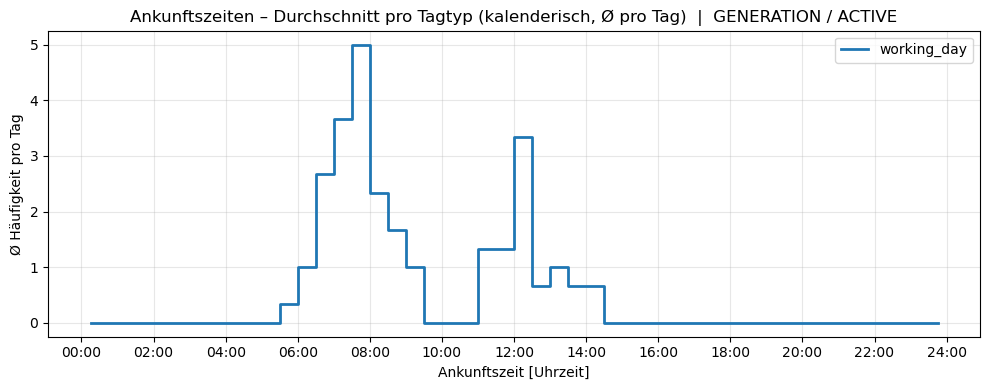

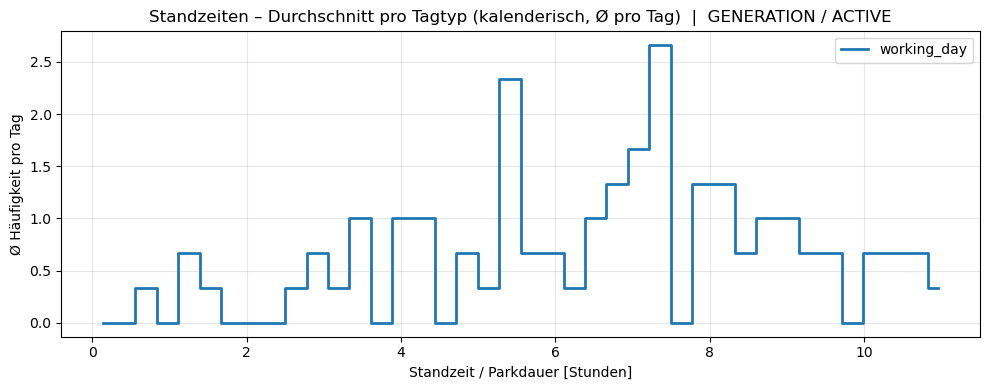

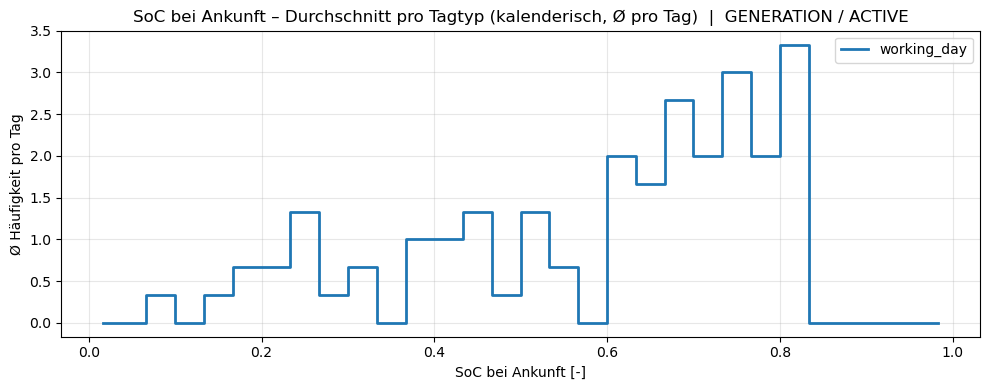

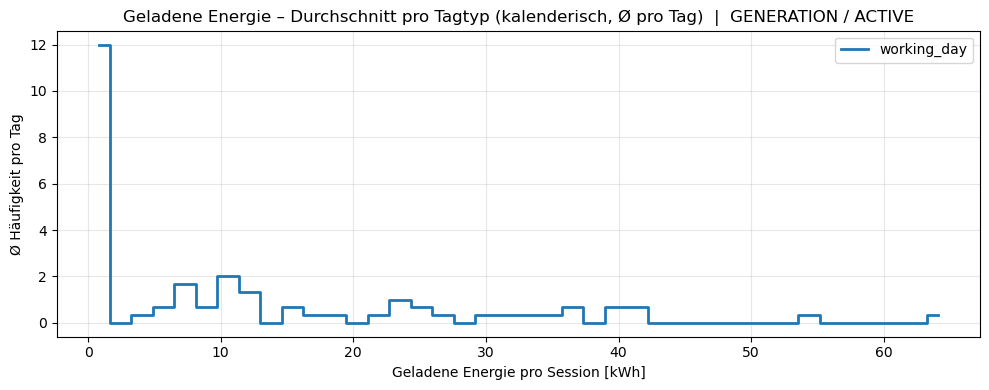

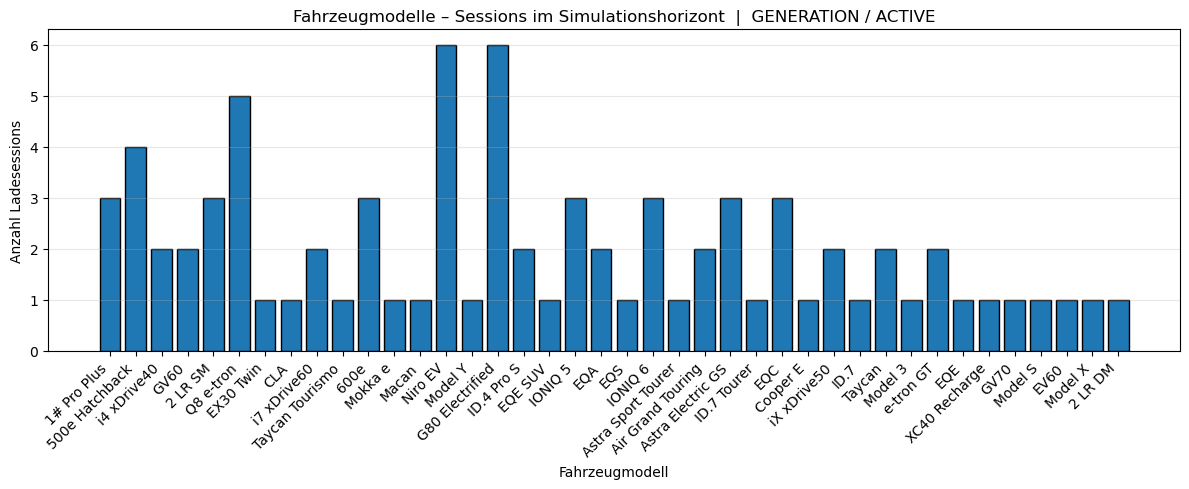

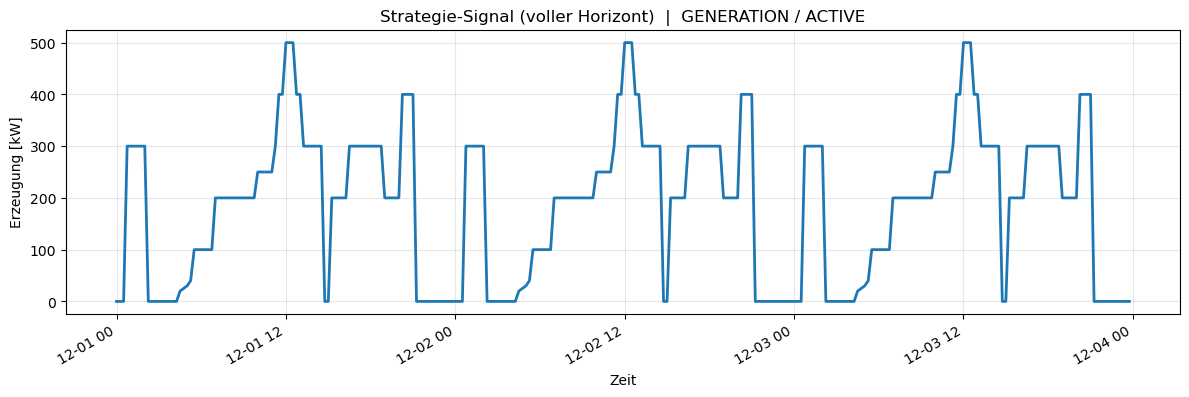

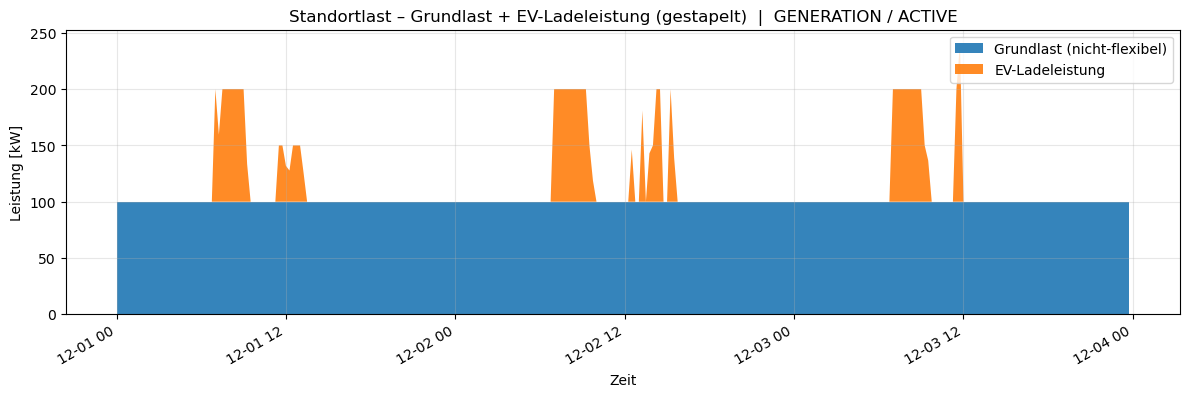

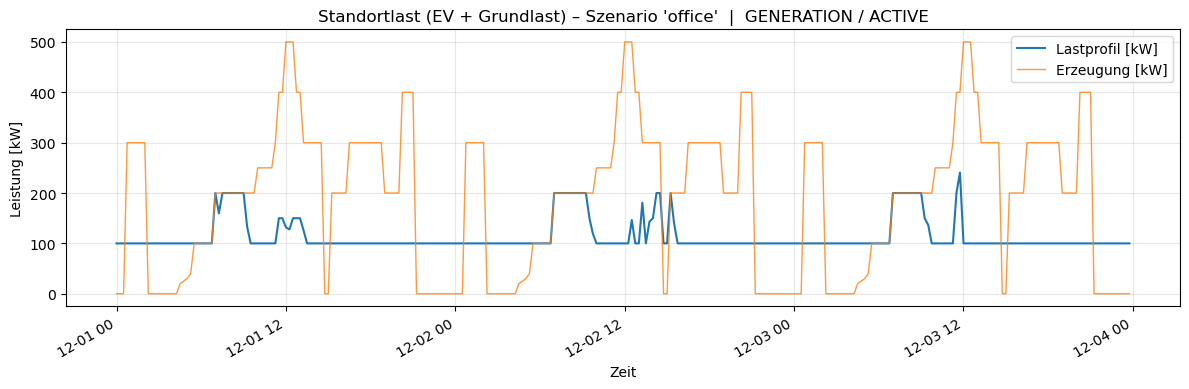

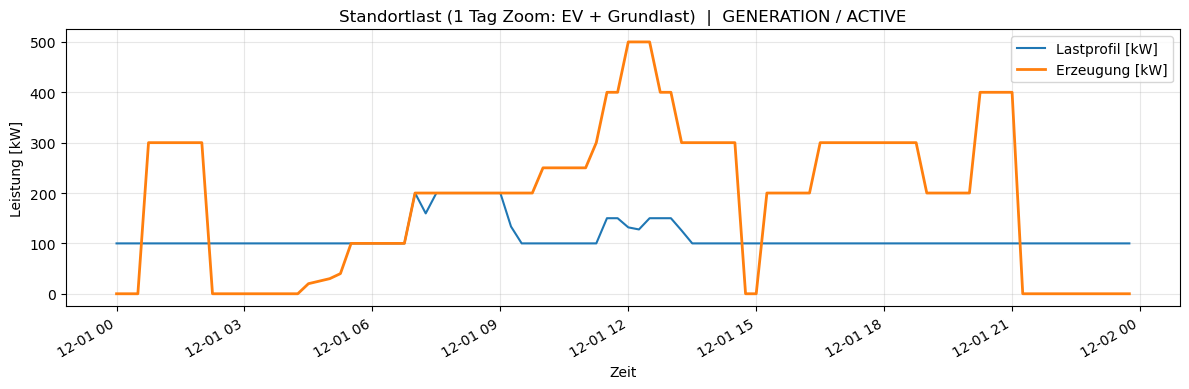


DEBUG – Netzbezug-Auswertung
Genutzte Netzimport-Spalte: grid_import_kw_site
Anzahl Debug-Zeilen insgesamt (nach Tagfilter ggf.): 48
Anzahl Debug-Zeilen mit Netzbezug: 0
Kein Netzbezug erkannt (Filter-Spalte überall ~0).
Min/Max: 0.0 1.4210854715202004e-14

🔎 Zeitschritte mit ungenutztem PV-Strom: 23


,ts,pv_surplus_kw,site_power_kw,grid_import_kw,n_rows,pv_unused_kw
1,2025-12-01 07:15:00,100.0,59.549024,0.0,2,40.450976
9,2025-12-01 09:15:00,100.0,33.457020,0.0,2,66.542980
10,2025-12-01 11:30:00,300.0,50.000000,0.0,1,250.000000
11,2025-12-01 11:45:00,300.0,50.000000,0.0,1,250.000000
12,2025-12-01 12:00:00,400.0,31.817501,0.0,1,368.182499
13,2025-12-01 12:15:00,400.0,27.673328,0.0,1,372.326672
14,2025-12-01 12:30:00,400.0,50.000000,0.0,1,350.000000
15,2025-12-01 12:45:00,300.0,50.000000,0.0,1,250.000000
16,2025-12-01 13:00:00,300.0,50.000000,0.0,1,250.000000
17,2025-12-01 13:15:00,200.0,25.585944,0.0,1,174.414056


Hinweis: 'energy_required_kwh' ist i.d.R. nicht Teil von debug_rows, daher hier nicht prüfbar.


In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from collections import Counter, defaultdict
from datetime import datetime, timedelta, date

warnings.simplefilter("always", UserWarning)
from IPython.display import display, HTML


# =============================================================================
# 0) Notebook-UI Helpers
# =============================================================================

def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 1) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import load_scenario, simulate_load_profile

# build_strategy_signal_series ist optional (kann in älteren Versionen fehlen)
try:
    from model.simulation import build_strategy_signal_series  # optional
except Exception:
    build_strategy_signal_series = None


# =============================================================================
# 2) Szenario laden und Simulation durchführen
# =============================================================================

scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)


try: 
    (
    timestamps,
    load_kw,
    sessions,
    charging_counts,
    holiday_dates,
    charging_strategy,
    strategy_status,
    debug_rows,
) = simulate_load_profile(scenario, record_debug=True)



except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    timestamps = load_kw = sessions = charging_counts = holiday_dates = None
    charging_strategy = strategy_status = None
    debug_rows = None

if charging_strategy is not None and strategy_status is not None:
    show_strategy_status_html(charging_strategy, strategy_status)
    print(f"Charging strategy: {charging_strategy.upper()}")
    print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 2b) Strategie-Signalreihe (aligned) + Labels (optional)
# =============================================================================

strategy_series = None
strategy_ylabel = None

if (
    timestamps is not None
    and charging_strategy is not None
    and charging_strategy.lower() in ("market", "generation")
    and build_strategy_signal_series is not None
):
    strategy_series, strategy_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy=charging_strategy,
        normalize_to_internal=True,   # market -> €/kWh, generation -> kW
        strategy_resolution_min=15,
    )


# =============================================================================
# 3) Kontrollen
# =============================================================================

if timestamps is not None:
    print("Verwendetes Szenario:", scenario_name)
    print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
    print(f"Erster Timestamp: {timestamps[0]}")
    print(f"Letzter Timestamp: {timestamps[-1]}")
    print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 4) Day-Type-Logik lokal im Notebook
# =============================================================================

def determine_day_type_notebook(dt: datetime, holiday_dates: set[date]):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"


# =============================================================================
# 5) Feature-Helper pro Session
# =============================================================================

def minutes_since_midnight(dt: datetime) -> float:
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s) -> float:
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s) -> float:
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s) -> float:
    return float(s["soc_arrival"])

def feat_delivered_kwh(s) -> float:
    return float(s.get("delivered_energy_kwh", 0.0))


# =============================================================================
# 6) Tage kalendarisch zählen
# =============================================================================

days_by_type_calendar = defaultdict(list)

if timestamps is not None and holiday_dates is not None:
    start_dt = datetime.fromisoformat(scenario["start_datetime"])
    horizon_days = int(scenario["simulation_horizon_days"])
    all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

    for d in all_days:
        dt_midday = datetime(d.year, d.month, d.day, 12, 0)
        day_type = determine_day_type_notebook(dt_midday, holiday_dates)
        days_by_type_calendar[day_type].append(d)

    print("Kalenderische Tage je Tagtyp:")
    for k in ["working_day", "saturday", "sunday_holiday"]:
        print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Kontrollen: Sessions (robust + ohne _session_uid-KeyError)
# =============================================================================

print("arrival_blocking_policy in YAML:", scenario["site"].get("arrival_blocking_policy"))
print("max_wait_minutes in YAML:", scenario["site"].get("max_wait_minutes"))

df_debug = pd.DataFrame(debug_rows) if debug_rows else pd.DataFrame()

# (A) Session UID im Notebook sicher setzen (falls simulation.py sie nicht setzt)
if sessions is not None:
    for idx, s in enumerate(sessions):
        if "_session_uid" not in s:
            s["_session_uid"] = f"{idx}_{s['arrival_time'].isoformat()}_{s['departure_time'].isoformat()}"

if sessions is not None:
    num_sessions_total = len(sessions)

    # Physisch angesteckt = hatte mindestens einmal _plug_in_time
    num_sessions_plugged = sum(1 for s in sessions if s.get("_plug_in_time") is not None)

    print("\n📊 Sessions im Simulationshorizont")
    print("Sessions gesamt (Ankünfte mit Ladebedarf):", num_sessions_total)
    print("Sessions physisch angesteckt:", num_sessions_plugged)

    # optional: Arrival-Blocking KPIs (wenn du sie behalten willst)
    num_rejected = sum(1 for s in sessions if bool(s.get("_rejected", False)))
    num_parked_no_charge = sum(1 for s in sessions if bool(s.get("_parked_no_charge", False)))

    print("\n🚦 Arrival-Blocking KPIs")
    print("Rejected (drive_off / max_wait):", num_rejected)
    print("Parked but not charged:", num_parked_no_charge)

    print("\n🔎 Beispiel-Sessions (erste 10):")
    for s in sessions[:10]:
        print(
            f"Fahrzeug: {s.get('vehicle_name','')}, "
            f"Ankunft: {s['arrival_time']}, "
            f"Abfahrt: {s['departure_time']}, "
            f"Kapazität: {s['battery_capacity_kwh']:.1f} kWh, "
            f"geladene Energie: {float(s.get('delivered_energy_kwh', 0.0)):.1f} kWh, "
            f"Restbedarf: {float(s.get('energy_required_kwh', 0.0)):.1f} kWh, "
            f"angesteckt: {'Ja' if s.get('_plug_in_time') else 'Nein'}"
        )


# =============================================================================
# 8) Sessions nach Datum gruppieren (für Histogramme pro Tag)
# =============================================================================

sessions_by_day = defaultdict(list)
if sessions is not None:
    for s in sessions:
        sessions_by_day[s["arrival_time"].date()].append(s)


# =============================================================================
# 9) Histogramm-Helfer
# =============================================================================

def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(
    avg_counts_by_type,
    bin_edges,
    xlabel,
    base_title,
    charging_strategy,
    strategy_status,
    xticks=None,
    xtick_labels=None,
):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 10) Ankunftszeiten
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    arrival_bin_edges = np.linspace(0, 24, 49)

    avg_arrival = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_arrival_hours,
        bin_edges=arrival_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_arrival,
        bin_edges=arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )


# =============================================================================
# 11) Standzeiten
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
    max_p = max(max_p, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)

    avg_parking = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_parking_hours,
        bin_edges=parking_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_parking,
        bin_edges=parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 12) SoC bei Ankunft
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    soc_bin_edges = np.linspace(0, 1, 31)

    avg_soc = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_soc_arrival,
        bin_edges=soc_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_soc,
        bin_edges=soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 13) Geladene Energie
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
    max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
    max_e = max(max_e, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)

    avg_energy = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_delivered_kwh,
        bin_edges=energy_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_energy,
        bin_edges=energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 14) Fahrzeugzählung (Achtung: Modelle können mehrfach vorkommen)
# =============================================================================

if sessions is not None:
    vehicle_names = [s.get("vehicle_name", "") for s in sessions]
    counts = Counter(vehicle_names)

    models = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(12, 5))
    plt.bar(models, values, edgecolor="black")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Fahrzeugmodell")
    plt.ylabel("Anzahl Ladesessions")
    plt.title(decorate_title_with_status("Fahrzeugmodelle – Sessions im Simulationshorizont", charging_strategy, strategy_status))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# =============================================================================
# 15) Strategy-Only Plot (optional)
# =============================================================================

if timestamps is not None and strategy_series is not None and strategy_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, strategy_series, linewidth=2)
    plt.xlabel("Zeit")
    plt.ylabel(strategy_ylabel)
    plt.title(decorate_title_with_status("Strategie-Signal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 16) Lastprofil + Strategie integriert (optional)
# =============================================================================

def plot_load_with_strategy(
    timestamps: list[datetime],
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]

    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    l1 = ax1.plot(x, y_load, label="Lastprofil [kW]")
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Lastprofil [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            l2 = ax2.plot(x, y_sig, linewidth=strategy_linewidth, alpha=strategy_alpha, label=strategy_ylabel)
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]

        elif strat == "generation":
            l2 = ax1.plot(x, y_sig, linewidth=strategy_linewidth, alpha=strategy_alpha, label=strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# =============================================================================
# Zusatz: Grundlast-Zeitreihe für Notebook-Plots aufbauen (optional)
# =============================================================================

from model.simulation import build_base_load_series

base_load_kw_series = None
if timestamps is not None:
    base_load_kw_series = build_base_load_series(
        scenario=scenario,
        timestamps=timestamps,
        base_load_resolution_min=15,
    )

if base_load_kw_series is None and load_kw is not None:
    base_load_kw_series = np.zeros_like(load_kw)

if load_kw is not None and base_load_kw_series is not None:
    site_load_kw = load_kw + base_load_kw_series
else:
    site_load_kw = load_kw


# =============================================================================
# 17) Standortlast – gestapelt: Grundlast + EV-Last
# =============================================================================

if timestamps is not None and load_kw is not None and base_load_kw_series is not None:
    plt.figure(figsize=(12, 4))
    plt.stackplot(
        timestamps,
        base_load_kw_series,
        load_kw,
        labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
        alpha=0.9,
    )
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(decorate_title_with_status("Standortlast – Grundlast + EV-Ladeleistung (gestapelt)", charging_strategy, strategy_status))
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 18) Standortlast (EV + Grundlast) – voller Horizont
# =============================================================================

if timestamps is not None and site_load_kw is not None:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )


# =============================================================================
# 19) Standortlast (EV + Grundlast) – 1 Tag Zoom
# =============================================================================

if timestamps is not None and site_load_kw is not None:
    steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
    )


# =============================================================================
# 20) DEBUG: Details der Zeitschritte mit Netzbezug (robust)
# =============================================================================

if debug_rows is not None and len(debug_rows) > 0:
    df_debug = pd.DataFrame(debug_rows).copy()

    # Datetime sicherstellen
    if "ts" in df_debug.columns:
        df_debug["ts"] = pd.to_datetime(df_debug["ts"], errors="coerce")

    # Netzimport-Spalte wählen
    grid_col = None
    candidate_cols = [
        "grid_import_kw_site",
        "grid_import_kw",
        "grid_import_kw_session_physical",
        "grid_import_kw_session",
        "grid_import_kw_session_policy",
    ]
    for c in candidate_cols:
        if c in df_debug.columns:
            grid_col = c
            break

    print("\nDEBUG – Netzbezug-Auswertung")
    print("Genutzte Netzimport-Spalte:", grid_col)

    if grid_col is None:
        print("Keine Netzimport-Spalte gefunden. Vorhandene Spalten:", list(df_debug.columns))
    else:
        # optional: nur erster Tag
        if timestamps is not None and "ts" in df_debug.columns and len(timestamps) > 0:
            day0 = timestamps[0].date()
            df_debug = df_debug[df_debug["ts"].dt.date == day0].copy()

        df_grid = df_debug[df_debug[grid_col] > 1e-6].copy()

        print("Anzahl Debug-Zeilen insgesamt (nach Tagfilter ggf.):", len(df_debug))
        print("Anzahl Debug-Zeilen mit Netzbezug:", len(df_grid))

        if len(df_grid) == 0:
            print("Kein Netzbezug erkannt (Filter-Spalte überall ~0).")
            print("Min/Max:", float(df_debug[grid_col].min()), float(df_debug[grid_col].max()))
        else:
            if "ts" in df_grid.columns:
                print("Anzahl Zeitschritte mit Netzbezug:", df_grid["ts"].nunique())

                agg_fn = "max" if grid_col in ("grid_import_kw_site", "grid_import_kw") else "sum"
                top_steps = (
                    df_grid.groupby("ts")[grid_col]
                    .agg(agg_fn)
                    .sort_values(ascending=False)
                    .head(10)
                )
                display(top_steps)

                for ts in top_steps.index:
                    block = df_grid[df_grid["ts"] == ts].copy()

                    # Sortierung: Emergency zuerst, dann kleinster Slack
                    if "is_emergency" in block.columns and "slack_minutes" in block.columns:
                        block = block.sort_values(["is_emergency", "slack_minutes"], ascending=[False, True])

                    cols = [
                        "vehicle_name",
                        "slack_minutes",
                        "is_emergency",
                        "site_total_power_kw",
                        "pv_surplus_kw",
                        "grid_import_kw_site",
                        "grid_import_kw_session_physical",
                        "grid_import_kw_session_policy",
                    ]
                    cols = [c for c in cols if c in block.columns]

                    print(f"\n=== Netzbezug-Zeitschritt: {ts} ===")
                    display(block[cols])
            else:
                print("Spalte 'ts' fehlt im Debug-Export – kann keine Zeitschritte gruppieren.")
                display(df_grid.head(50))
else:
    print("\nDEBUG – keine debug_rows vorhanden (record_debug=True aktivieren oder Simulation abgebrochen).")


# =============================================================================
# 21) PV-Nutzung analysieren (nur wenn generation + passende Spalten existieren)
# =============================================================================

if debug_rows is not None and len(debug_rows) > 0:
    df_debug = pd.DataFrame(debug_rows).copy()
    if "ts" in df_debug.columns:
        df_debug["ts"] = pd.to_datetime(df_debug["ts"], errors="coerce")

    required_cols = {"ts", "pv_surplus_kw", "site_total_power_kw"}
    if required_cols.issubset(df_debug.columns):
        df_pv = df_debug[df_debug["pv_surplus_kw"] > 1e-6].copy()

        pv_steps = (
            df_pv
            .groupby("ts")
            .agg(
                pv_surplus_kw=("pv_surplus_kw", "first"),
                site_power_kw=("site_total_power_kw", "first"),
                grid_import_kw=("grid_import_kw_site", "first") if "grid_import_kw_site" in df_pv.columns else ("site_total_power_kw", "first"),
                n_rows=("vehicle_name", "count") if "vehicle_name" in df_pv.columns else ("pv_surplus_kw", "size"),
            )
            .reset_index()
        )

        pv_steps["pv_unused_kw"] = (pv_steps["pv_surplus_kw"] - pv_steps["site_power_kw"]).clip(lower=0.0)
        pv_unused_steps = pv_steps[pv_steps["pv_unused_kw"] > 1e-3]

        print(f"\n🔎 Zeitschritte mit ungenutztem PV-Strom: {len(pv_unused_steps)}")
        display(pv_unused_steps.head(10))

        print("Hinweis: 'energy_required_kwh' ist i.d.R. nicht Teil von debug_rows, daher hier nicht prüfbar.")
    else:
        print("\nPV-Analyse übersprungen – benötigte Spalten fehlen.")
        print("Benötigt:", required_cols)
        print("Vorhanden:", set(df_debug.columns))
